In [4]:
import pandas as pd

def preprocess_index_data(df):
    # 1. Convert 'Date' to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # 2. Drop 'Index' column if it's constant
    if df['Index'].nunique() == 1:
        df.drop(columns=['Index'], inplace=True)
    
    # 3. Sort by date
    df.sort_values('Date', inplace=True)

    # 4. Forward fill missing values 
    df.ffill(inplace=True)

    # 5. Backward fill to handle initial missing values
    df.bfill(inplace=True)

    # 6. Drop 'Volume' column if all values are 0 (no information)
    if df['Volume'].nunique() == 1 and df['Volume'].unique()[0] == 0.0:
        df.drop(columns=['Volume'], inplace=True)

    # 7. Reset index
    df.reset_index(drop=True, inplace=True)
    
    return df

In [5]:
df = pd.read_excel("E:\\downloads\\indexData.xlsx")
df = preprocess_index_data(df)

# Check the cleaned result
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112457 entries, 0 to 112456
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Index      112457 non-null  object        
 1   Date       112457 non-null  datetime64[ns]
 2   Open       112457 non-null  float64       
 3   High       112457 non-null  float64       
 4   Low        112457 non-null  float64       
 5   Close      112457 non-null  float64       
 6   Adj Close  112457 non-null  float64       
 7   Volume     112457 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB
None
  Index       Date         Open         High          Low        Close  \
0  N225 1965-01-05  1257.719971  1257.719971  1257.719971  1257.719971   
1  N225 1965-01-06  1263.989990  1263.989990  1263.989990  1263.989990   
2  N225 1965-01-07  1274.270020  1274.270020  1274.270020  1274.270020   
3  N225 1965-01-08  1286.430054  1286.

In [6]:
df.isnull().sum()

Index        0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

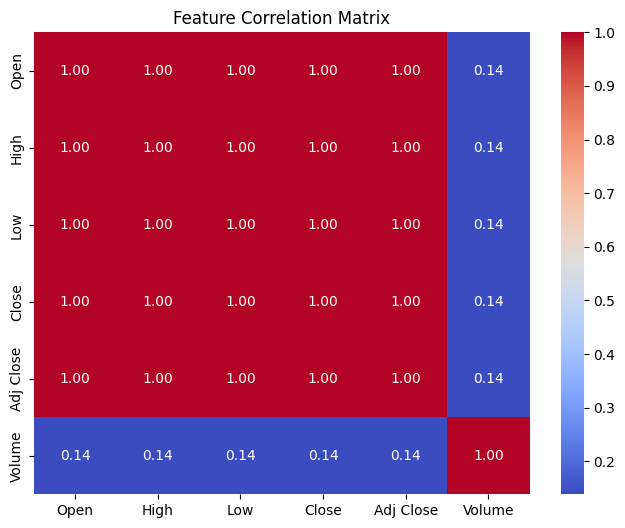

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use the preprocessed DataFrame
df_clean = preprocess_index_data(df)

# Extract numerical features only
numeric_df = df_clean.select_dtypes(include='number')

# Correlation matrix
correlation = numeric_df.corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


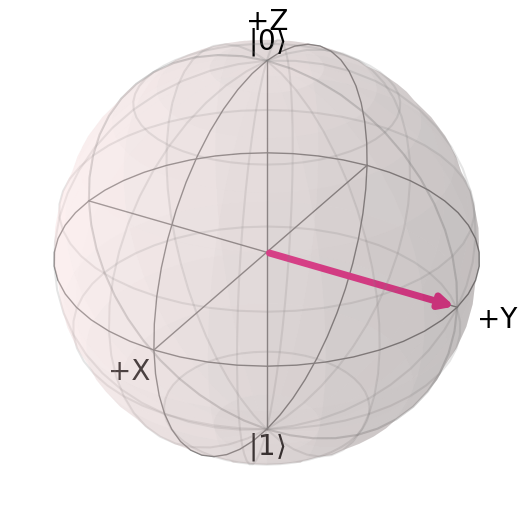

In [28]:
from qiskit.visualization.bloch import Bloch
import matplotlib.pyplot as plt

# Example Bloch vector (replace with your actual qubit's vector)
bloch_vec = [0, 1, 0]  # You can change this to any [x, y, z]

# Create Bloch sphere object
b = Bloch()

# Add Bloch vector
b.add_vectors(bloch_vec)

# Set axis labels
b.xlabel = ['+X', '']
b.ylabel = ['+Y', '']
b.zlabel = ['+Z', '']

# Add annotations for |0⟩ and |1⟩ states
b.annotations = [
    {'position': (0, 0, 1.1), 'text': r'$|0\rangle$', 'opts': {}},
    {'position': (0, 0, -1.1), 'text': r'$|1\rangle$', 'opts': {}}
]

# Optional title
b.title = "Bloch Sphere with |0⟩ and |1⟩ Labels"

# Display the Bloch sphere
b.show()


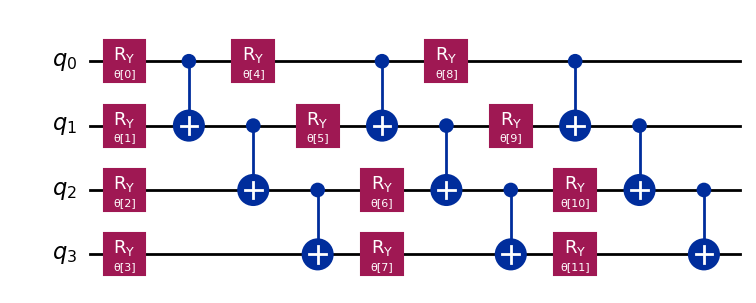

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

# Define variational form
num_qubits = 4
depth = 3
params = ParameterVector('θ', length=num_qubits * depth)

qc = QuantumCircuit(num_qubits)

# Add parameterized Ry gates and entangling layers
param_idx = 0
for d in range(depth):
    for q in range(num_qubits):
        qc.ry(params[param_idx], q)
        param_idx += 1
    for q in range(num_qubits - 1):
        qc.cx(q, q + 1)

# Draw circuit
qc.draw('mpl')


In [25]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import EstimatorQNN

# Number of qubits = number of features
num_qubits = X_train.shape[1]

# Feature map (input encoding)
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=1)

# Ansatz (parameterized circuit)
ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks='ry', entanglement_blocks='cz', reps=2)

# Combine feature map and ansatz into a full quantum circuit
params = ParameterVector("θ", ansatz.num_parameters)
qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz.assign_parameters(params), inplace=True)

# Estimator-based QNN
qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=params)

# Wrap with regressor
regressor = NeuralNetworkRegressor(neural_network=qnn)

# Train the model
regressor.fit(X_train_scaled, y_train)


C:\Users\Admin\AppData\Local\Temp\ipykernel_20588\3877035695.py:21: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=params)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit_algorithms.optimizers import SLSQP

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 2)
y = 3 * X[:, 0] + 2 * X[:, 1] + 1

# Split raw data before normalization
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize input and output
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_raw_train)
X_test = scaler_X.transform(X_raw_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_raw_train.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_raw_test.reshape(-1, 1)).ravel()

# Define quantum circuit
num_qubits = X.shape[1]
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Build QNN
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

# Set optimizer
optimizer = SLSQP(maxiter=300)

# Build and train regressor
regressor = NeuralNetworkRegressor(neural_network=qnn, optimizer=optimizer)
regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred = regressor.predict(X_test)

# Inverse transform to original scale
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_test_original = y_raw_test

# Evaluation Metrics
mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_19056\1136140954.py:42: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19056\1136140954.py:43: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Mean Squared Error (MSE): 0.1691
Mean Absolute Error (MAE): 0.3946
R-squared (R²): 0.7440


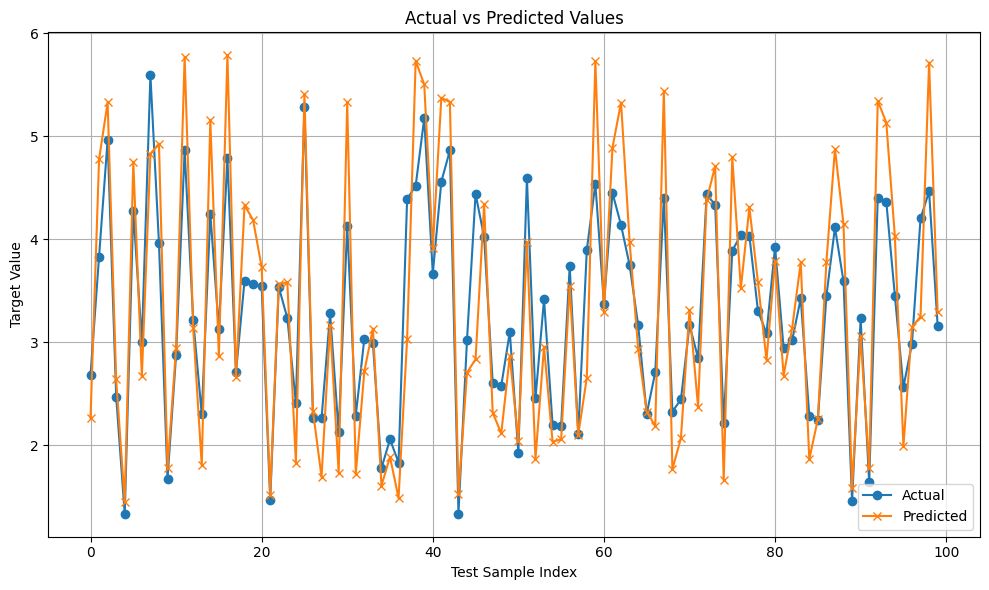

In [7]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(y_pred_original, label='Predicted', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator

from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit_algorithms.optimizers import SLSQP


# Generate synthetic data
np.random.seed(42)
X = np.random.rand(500, 2)
y = 3 * X[:, 0] + 2 * X[:, 1] + 1

# Split raw data before normalization
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize input and output
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_raw_train)
X_test = scaler_X.transform(X_raw_test)

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_raw_train.reshape(-1, 1)).ravel()
y_test = scaler_y.transform(y_raw_test.reshape(-1, 1)).ravel()

# Define quantum circuit
num_qubits = X.shape[1]
feature_map = ZFeatureMap(feature_dimension=num_qubits, reps=2)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Build QNN
estimator = Estimator()
qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

# Set optimizer
optimizer = SLSQP(maxiter=300)

# Build and train regressor
regressor = NeuralNetworkRegressor(neural_network=qnn, optimizer=optimizer)
regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred = regressor.predict(X_test)

# Inverse transform to original scale
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).ravel()
y_test_original = y_raw_test

mse = mean_squared_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)


print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")


C:\Users\Admin\AppData\Local\Temp\ipykernel_19056\302488185.py:43: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19056\302488185.py:44: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Mean Squared Error (MSE): 0.3323
Mean Absolute Error (MAE): 0.4494
R-squared (R²): 0.6618


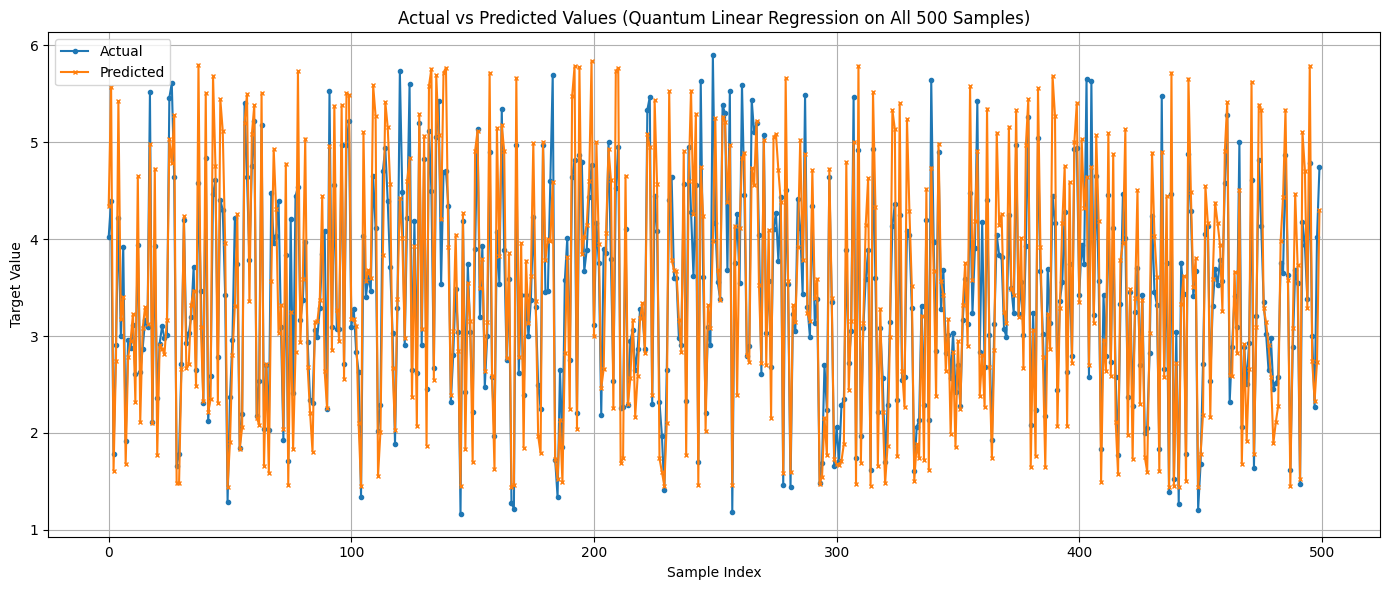

In [12]:
# Plot all 500 predictions as a line graph
plt.figure(figsize=(14, 6))
plt.plot(y, label='Actual', linestyle='-', marker='o', markersize=3)
plt.plot(y_pred_all_original, label='Predicted', linestyle='-', marker='x', markersize=3)
plt.title('Actual vs Predicted Values (Quantum Linear Regression on All 500 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
